In [9]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.applications.imagenet_utils import preprocess_input

base_model = keras.applications.VGG16(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False)

In [10]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [11]:
base_model.trainable = False

In [12]:
inputs = keras.Input(shape=(224, 224, 3))
# Separately from setting trainable on the model, we set training to False 
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [13]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_1  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 14715201 (56.13 MB)
Trainable params: 513 (2.00 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [14]:
# Important to use binary crossentropy and binary accuracy as we now have a binary classification problem
model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True), metrics=[keras.metrics.BinaryAccuracy()])

In [15]:

# Create a data generator
datagen_train = ImageDataGenerator(
    samplewise_center=True,  # set each sample mean to 0
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.1,  # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False,
)  # we don't expect Bo to be upside-down so we will not flip vertically

# No need to augment validation data
datagen_valid = ImageDataGenerator(samplewise_center=True)

In [17]:
# load and iterate training dataset
train_it = datagen_train.flow_from_directory(
    "data/presidential_doggy_door/train/",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="binary",
    batch_size=8,
)

# load and iterate validation dataset
valid_it = datagen_valid.flow_from_directory(
    "data/presidential_doggy_door/valid/",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="binary",
    batch_size=8,
)

Found 139 images belonging to 2 classes.
Found 30 images belonging to 2 classes.


In [18]:
model.fit(train_it, steps_per_epoch=12, validation_data=valid_it, validation_steps=4, epochs=20)

Epoch 1/20
12/12 [==============================] - 11s 945ms/step - loss: 0.5927 - binary_accuracy: 0.7912 - val_loss: 0.5955 - val_binary_accuracy: 0.8333
Epoch 2/20
12/12 [==============================] - 10s 918ms/step - loss: 0.3456 - binary_accuracy: 0.8462 - val_loss: 0.3908 - val_binary_accuracy: 0.8333
Epoch 3/20
12/12 [==============================] - 11s 901ms/step - loss: 0.1557 - binary_accuracy: 0.9341 - val_loss: 0.2484 - val_binary_accuracy: 0.8667
Epoch 4/20
12/12 [==============================] - 11s 904ms/step - loss: 0.0546 - binary_accuracy: 0.9780 - val_loss: 0.2621 - val_binary_accuracy: 0.8667
Epoch 5/20
12/12 [==============================] - 11s 915ms/step - loss: 0.1964 - binary_accuracy: 0.8901 - val_loss: 0.1353 - val_binary_accuracy: 0.9333
Epoch 6/20
12/12 [==============================] - 11s 934ms/step - loss: 0.0830 - binary_accuracy: 0.9560 - val_loss: 0.1472 - val_binary_accuracy: 0.9000
Epoch 7/20
12/12 [==============================] - 11s 92

In [20]:
# Unfreeze the base model
base_model.trainable = True

# It's important to recompile your model after you make any changes
# to the `trainable` attribute of any inner layer, so that your changes
# are taken into account
model.compile(optimizer=keras.optimizers.legacy.RMSprop(learning_rate = .00001),  # Very low learning rate
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

In [21]:
model.fit(train_it, steps_per_epoch=12, validation_data=valid_it, validation_steps=4, epochs=10)

Epoch 1/10
12/12 [==============================] - 30s 2s/step - loss: 3.1057e-04 - binary_accuracy: 1.0000 - val_loss: 0.1608 - val_binary_accuracy: 0.9667
Epoch 2/10
12/12 [==============================] - 30s 3s/step - loss: 0.1911 - binary_accuracy: 0.9890 - val_loss: 0.0232 - val_binary_accuracy: 1.0000
Epoch 3/10
12/12 [==============================] - 32s 3s/step - loss: 1.0994e-04 - binary_accuracy: 1.0000 - val_loss: 0.0266 - val_binary_accuracy: 1.0000
Epoch 4/10
12/12 [==============================] - 32s 3s/step - loss: 9.4121e-05 - binary_accuracy: 1.0000 - val_loss: 0.0332 - val_binary_accuracy: 0.9667
Epoch 5/10
12/12 [==============================] - 33s 3s/step - loss: 1.1917e-04 - binary_accuracy: 1.0000 - val_loss: 0.0369 - val_binary_accuracy: 0.9667
Epoch 6/10
12/12 [==============================] - 32s 3s/step - loss: 3.6538e-07 - binary_accuracy: 1.0000 - val_loss: 0.0370 - val_binary_accuracy: 0.9667
Epoch 7/10
12/12 [==============================] - 32s 

In [22]:
#examining predictions made by the model

def show_image(image_path):
    image = mpimg.imread(image_path)
    plt.imshow(image)

def make_predictions(image_path):
    show_image(image_path)
    image = image_utils.load_img(image_path, target_size=(224, 224))
    image = image_utils.img_to_array(image)
    image = image.reshape(1,224,224,3)
    image = preprocess_input(image)
    preds = model.predict(image)
    return preds

1/1 [==============================] - 0s 187ms/step


array([[-25.265984]], dtype=float32)

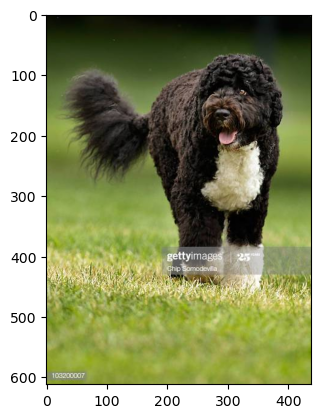

In [23]:
make_predictions('data/presidential_doggy_door/valid/bo/bo_20.jpg')

1/1 [==============================] - 0s 121ms/step


array([[22.360159]], dtype=float32)

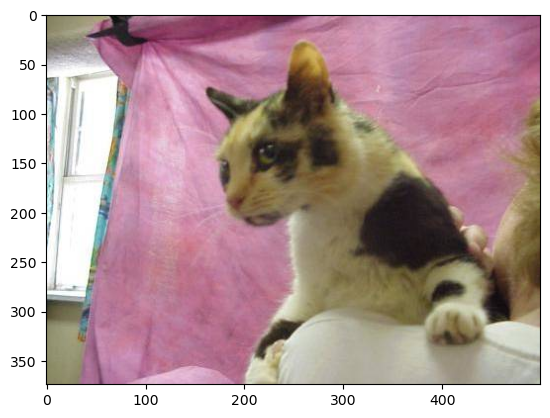

In [24]:
make_predictions('data/presidential_doggy_door/valid/not_bo/121.jpg')

In [25]:
# defining and running bo's dog door function
def presidential_doggy_door(image_path):
    preds = make_predictions(image_path)
    if preds[0] < 0:
        print("It's Bo! Let him in!")
    else:
        print("That's not Bo! Stay out!")

1/1 [==============================] - 0s 103ms/step
That's not Bo! Stay out!


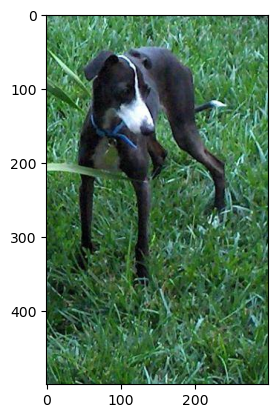

In [26]:
presidential_doggy_door('data/presidential_doggy_door/valid/not_bo/131.jpg')

1/1 [==============================] - 0s 103ms/step
It's Bo! Let him in!


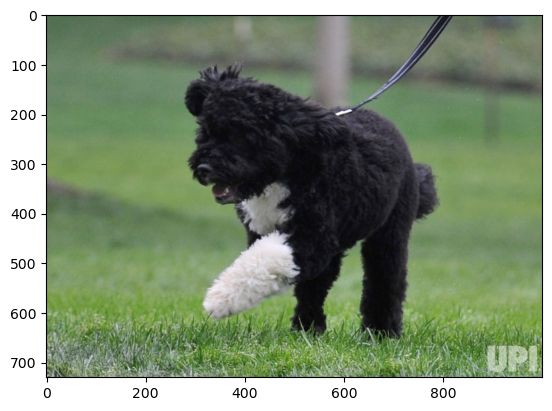

In [27]:
presidential_doggy_door('data/presidential_doggy_door/valid/bo/bo_29.jpg')